Num constraints:  9440
Num variables:  10449
Solver log file: 'log_check.log'
Solver solution file: 'C:\Users\Aero\AppData\Local\Temp\tmp4ju5lylx.pyomo.sol'
Solver problem files: ('C:\\Users\\Aero\\AppData\\Local\\Temp\\tmp4ju5lylx.pyomo.nl',)
Ipopt 3.14.13: halt_on_ampl_error=yes
tol=1e-06
dual_inf_tol=1e-06
constr_viol_tol=1e-06
max_iter=800
linear_scaling_on_demand=yes
nlp_scaling_method=gradient-based
linear_solver=ma27
ma27_pivtol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.13, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    43777
Number of nonzeros in inequality cons

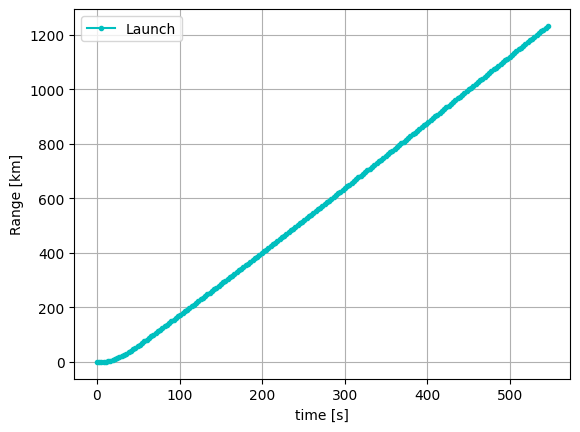

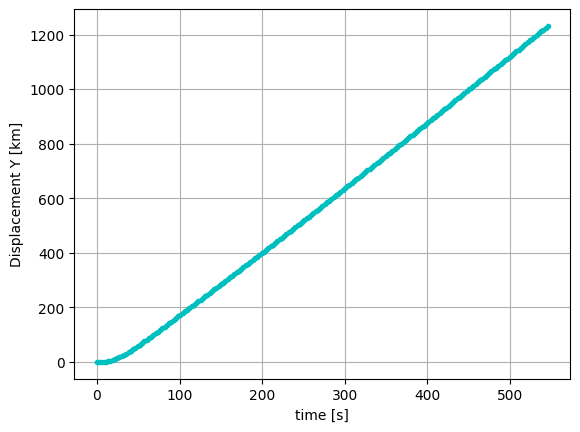

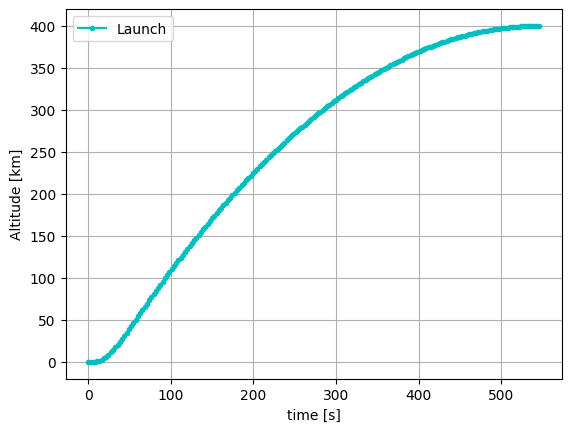

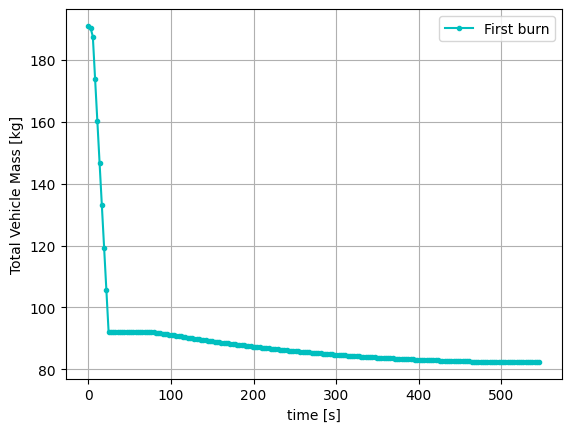

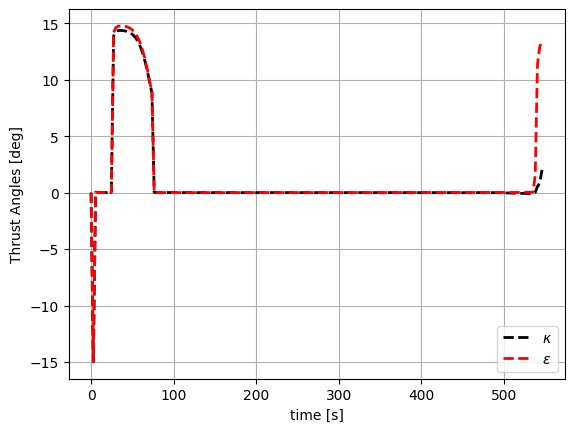

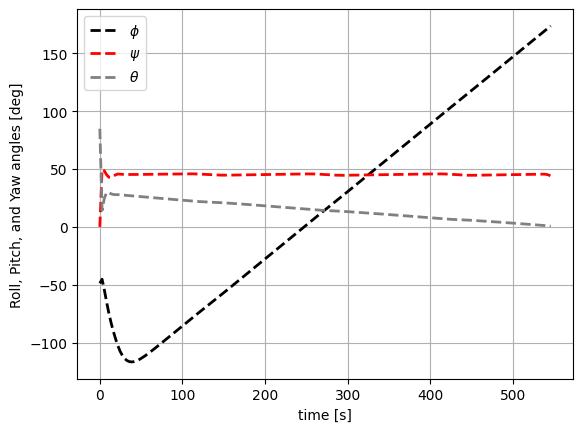

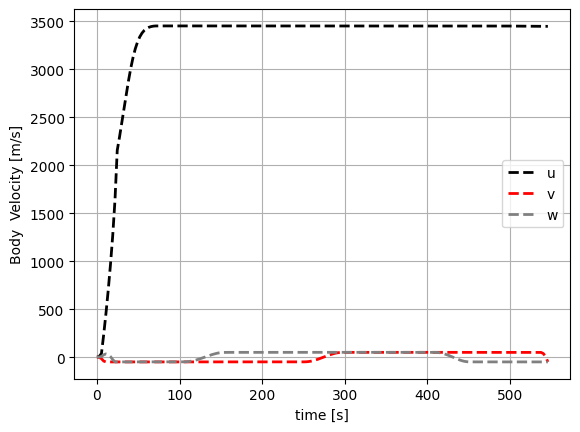

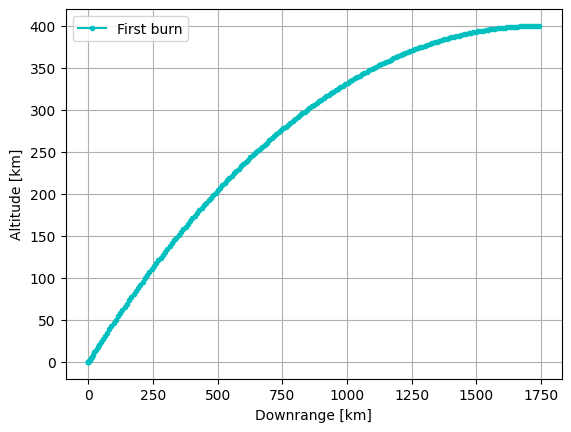

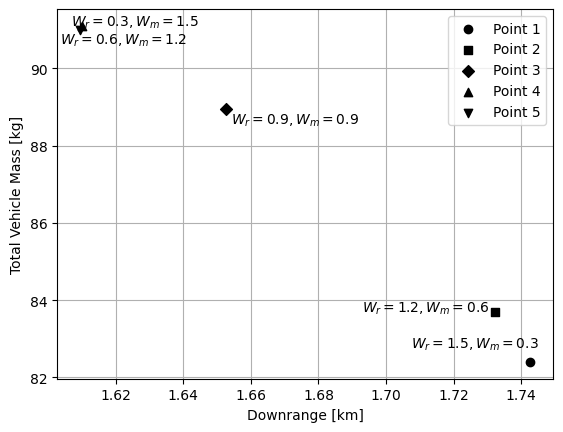

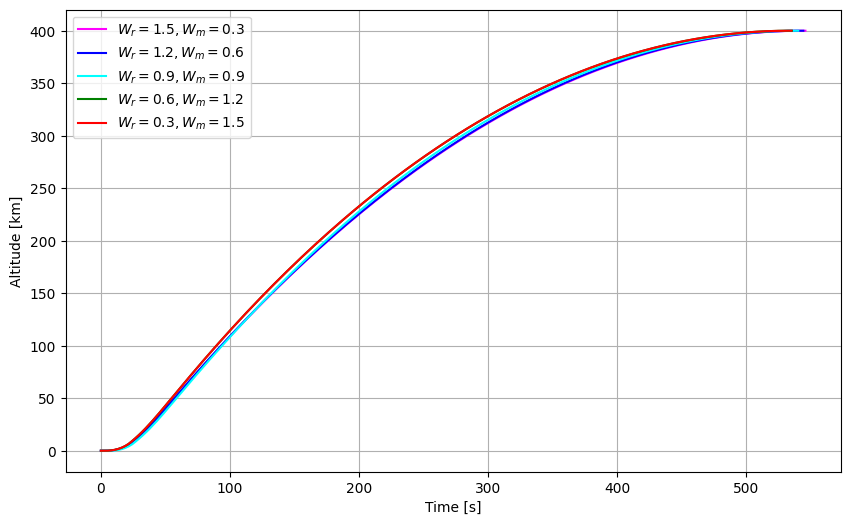

In [1]:
from pyomo.dae import ContinuousSet, DerivativeVar, Integral
from pyomo.environ import ConcreteModel, TransformationFactory, Var, \
                          NonNegativeReals, Constraint, ConstraintList, \
                          SolverFactory, Objective, cos, sin, tan, minimize, maximize,  \
                          NonNegativeReals, NegativeReals, Param, sqrt 
from pyomo.environ import *
from pyomo.dae import *
from math import isclose
import numpy as np
import csv
import os
import pandas as pd
import logging
import matplotlib.pyplot as plt
from MAV_Single import MAV
import Parameters as param
from Utilities.VarContainer_Single import VarContainer
from Utilities.Plotter_Single import plotResults
from Utilities.saveOptimizationVariables import saveOptimizationVariables
from Utilities.loadOptimizationVariables import loadOptimizationVariables
from pyomo.environ import Suffix, ConcreteModel, Var, NonNegativeReals, \
    Constraint, Objective, SolverFactory
# from idaes.core.util.scaling import (scale_constraints, ScalingBasis,
#                                  calculate_scaling_factors)
from scipy.interpolate import interp1d
from pyomo.util.infeasible import (
    find_infeasible_constraints,
    log_infeasible_constraints,
    find_infeasible_bounds,
    log_infeasible_bounds,
    find_close_to_bounds,
    log_close_to_bounds,
)

# Set up logging
logging.basicConfig(level=logging.INFO)  # Ensure logging level is INFO or DEBUG
logger = logging.getLogger('pyomo.core')

def main():
    
    miu_mars = 4.282837e13
    mars_radius = 3.3895e3

    # Initial and final conditions
    x0 = None
    y0 = None
    z0 = None

    u0 = None
    v0 = None
    w0 = None

    phi0 = None
    the0 = None
    psi0 = None
    
    p0 = None
    q0 = None
    r0 = None

    xf = None
    yf = None
    zf = None
    
    uf = None
    vf = None
    wf = None

    phif = None
    thef = None 
    psif = None
    
    pf = None
    qf = None
    rf = None

    # Initialize lists to store results
    final_mass_values = []
    final_downrange_values = []

    # Weightings 
    W_Obj1 = [0.3, 0.6, 0.9, 1.2, 1.5]
    W_Obj2 = [1.5, 1.2, 0.9, 0.6, 0.3]

    for weight in range(5):
        for warm in range(1):

            # Create mav vehicle
            mav = MAV(x0=x0, y0=y0, z0=z0, u0=u0, v0=v0, w0=w0, phi0=phi0, the0=the0, psi0=psi0, p0=p0, q0=q0, r0=r0, \
                    xf=xf, yf=yf, zf=zf, uf=uf, vf=vf, wf=wf, phif=phif, thef=thef, psif=psif, pf=pf, qf=qf, rf=rf)
        
            # Boundary Conditions
            mav.m.BCs_con = ConstraintList(rule=mav.BCs)
            
            # Phase 1
            n1 = [1] # flag for Phase 1

            mav.m.Q_dmpdot_dtau_Con1         = Constraint(n1, mav.m.t1, rule=mav.Q_dmass_dtau)

            mav.m.Q_dx_dtau_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_dx_dtau)
            mav.m.Q_dy_dtau_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_dy_dtau)
            mav.m.Q_dz_dtau_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_dz_dtau)

            mav.m.Q_du_dtau_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_du_dtau)
            mav.m.Q_dv_dtau_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_dv_dtau)
            mav.m.Q_dw_dtau_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_dw_dtau)

            mav.m.Q_dp_dtau_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_dp_dtau)
            mav.m.Q_dq_dtau_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_dq_dtau)
            mav.m.Q_dr_dtau_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_dr_dtau)

            mav.m.Q_dphi_dtau_Con1           = Constraint(n1, mav.m.t1, rule=mav.Q_dphi_dtau)
            mav.m.Q_dthe_dtau_Con1           = Constraint(n1, mav.m.t1, rule=mav.Q_dthe_dtau)
            mav.m.Q_dpsi_dtau_Con1           = Constraint(n1, mav.m.t1, rule=mav.Q_dpsi_dtau)
            mav.m.Q_massdot_Con1             = Constraint(n1, mav.m.t1, rule=mav.Q_massdot)

            mav.m.Q_pdot_Con1                = Constraint(n1, mav.m.t1, rule=mav.Q_pdot)
            mav.m.Q_qdot_Con1                = Constraint(n1, mav.m.t1, rule=mav.Q_qdot)   
            mav.m.Q_rdot_Con1                = Constraint(n1, mav.m.t1, rule=mav.Q_rdot)

            mav.m.Q_udot_Con1                = Constraint(n1, mav.m.t1, rule=mav.Q_udot)
            mav.m.Q_vdot_Con1                = Constraint(n1, mav.m.t1, rule=mav.Q_vdot)   
            mav.m.Q_wdot_Con1                = Constraint(n1, mav.m.t1, rule=mav.Q_wdot)

            mav.m.Q_q0_Con1                  = Constraint(n1, mav.m.t1, rule=mav.Q_q0)
            mav.m.Q_q1_Con1                  = Constraint(n1, mav.m.t1, rule=mav.Q_q1)
            mav.m.Q_q2_Con1                  = Constraint(n1, mav.m.t1, rule=mav.Q_q2)
            mav.m.Q_q3_Con1                  = Constraint(n1, mav.m.t1, rule=mav.Q_q3)

            mav.m.Q_phidot_Con1              = Constraint(n1, mav.m.t1, rule=mav.Q_phidot)
            mav.m.Q_thedot_Con1              = Constraint(n1, mav.m.t1, rule=mav.Q_thedot)
            mav.m.Q_psidot_Con1              = Constraint(n1, mav.m.t1, rule=mav.Q_psidot)

            mav.m.Q_u1_Con1                  = Constraint(n1, mav.m.t1, rule=mav.Q_u)
            mav.m.Q_v1_Con1                  = Constraint(n1, mav.m.t1, rule=mav.Q_v)
            mav.m.Q_w1_Con1                  = Constraint(n1, mav.m.t1, rule=mav.Q_w)

            # Define Objective
            mav.m.x = mav.m.x_1[1] 
            mav.m.y = mav.m.y_1[1] 
            mav.m.range = mav.m.x + mav.m.y
            mav.m.mass = mav.m.mass_1[1]
            mav.m.objective = Objective(expr=(((mav.m.mass**W_Obj1[weight]) * (mav.m.range**W_Obj2[weight]))), sense=maximize)

            # Warm start initial guess from previous solution
            # if warm > 0:
            #     loadOptimizationVariables(mav, myPyomoVars)

            # Dsicretized size description
            from pyomo.util.model_size import build_model_size_report
            report = build_model_size_report(mav.m)
            print("Num constraints: ", report.activated.constraints)
            print("Num variables: ", report.activated.variables)

            # Solve
            solver = SolverFactory('ipopt')
            solver.options["halt_on_ampl_error"] = "yes"
            solver.options['tol'] = 1e-6 
            solver.options['dual_inf_tol'] = 1e-6
            solver.options['constr_viol_tol'] = 1e-6
            solver.options["max_iter"] = 800
            solver.options["linear_scaling_on_demand"] = "yes"
            solver.options['nlp_scaling_method'] = 'gradient-based'
            solver.options['linear_solver'] = "ma27"
            solver.options["ma27_pivtol"] = 1e-6

            results = solver.solve(mav.m, tee=True, keepfiles=True, logfile="log_check.log")

            # Save all data for next warm start
            # if warm == 0:
            #     _,myPyomoVars = saveOptimizationVariables(mav)
    
    # %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

            # Retrieve and store final values for Pareto plot
            if warm == 0:
                final_mass_values.append(value(mav.m.mass_1[1] * mav.m.mass_scale))
                final_downrange_values.append(np.sqrt(value(mav.m.x_1[1] * mav.m.x_scale)**2 + value(mav.m.y_1[1] * mav.m.y_scale)**2) / 1e6)

        # Plot graphs for desired weight
        trajectory_vars = VarContainer(mav.m)
        if weight == 0 :
            plotResults(trajectory_vars, mav.m)

        results_list = []

        for t1 in mav.m.t1:
            results_list.append({
                't': t1 * value(mav.m.tf1),
                'x': value(mav.m.x_1[t1] * mav.m.x_scale),
                'y': value(mav.m.y_1[t1] * mav.m.y_scale),
                'downrange': sqrt(value(mav.m.x_1[t1] * mav.m.x_scale)**2 + value(mav.m.y_1[t1] * mav.m.y_scale)**2),
                'altitude': value(mav.m.z_1[t1] * mav.m.z_scale),
            })

        def export_to_csv(results_list, filename):
            keys = results_list[0].keys()
            with open(filename, 'w', newline='') as output_file:
                dict_writer = csv.DictWriter(output_file, fieldnames=keys)
                dict_writer.writeheader()
                dict_writer.writerows(results_list)
        export_to_csv(results_list, f'results1_{weight}.csv')

    plt.show()  

    
    labels = [f'$W_r={w2},W_m={w1}$' for w1, w2 in zip(W_Obj1, W_Obj2)]

    # Plot Pareto Front
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'H']
    plt.figure()

    for i in range(len(final_mass_values)):
        plt.scatter(final_downrange_values[i], final_mass_values[i], marker=markers[i % len(markers)], color='black', label=f'Point {i+1}')
        if i == 0:
            plt.annotate(labels[i % len(labels)], (final_downrange_values[i], final_mass_values[i]), textcoords="offset points", xytext=(-40, 10), ha='center')
        elif i == 1:
            plt.annotate(labels[i % len(labels)], (final_downrange_values[i], final_mass_values[i]), textcoords="offset points", xytext=(-50, 0), ha='center')
        elif i == 2:
            plt.annotate(labels[i % len(labels)], (final_downrange_values[i], final_mass_values[i]), textcoords="offset points", xytext=(50, -10), ha='center')
        elif i == 3:
            plt.annotate(labels[i % len(labels)], (final_downrange_values[i], final_mass_values[i]), textcoords="offset points", xytext=(30, -13), ha='center')
        elif i == 4:
            plt.annotate(labels[i % len(labels)], (final_downrange_values[i], final_mass_values[i]), textcoords="offset points", xytext=(40, 3), ha='center')

    plt.xlabel('Downrange [km]')
    plt.ylabel('Total Vehicle Mass [kg]')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Plot optimal trajectory histories
    file_paths = [f'results1_{i}.csv' for i in range(len(W_Obj1))]
    dfs = [pd.read_csv(file) for file in file_paths]
    colors = ['magenta', 'blue', 'cyan', 'green', 'red']

    fig2d, ax2d = plt.subplots(figsize=(10, 6))
    for df, label, color in zip(dfs, labels, colors):
        ax2d.plot(df['t'], df['altitude'] / 1000, label=label, color=color)
    ax2d.set_xlabel('Time [s]')
    ax2d.set_ylabel('Altitude [km]')
    ax2d.legend()
    ax2d.grid(True)
    plt.show()

    # Delete the result files
    for file_path in file_paths:
        if os.path.exists(file_path):
            os.remove(file_path)

    return mav.m

if __name__ == '__main__':
    m = main()